In [1]:
from fantasy_machine import update_data, import_data
from fantasy_machine import config
from fantasy_machine import stats
from fantasy_machine import model

import pandas as pd
import sqlite3

import numpy as np
from sklearn import linear_model
from sklearn import svm
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
# %matplotlib inline

import warnings
warnings.filterwarnings('ignore')

/Users/ryand/git/fantasy_machine


In [2]:
bullpen_dc = {"WHERE":{"pull_time":{"=":"(SELECT MAX(pull_time) FROM {table})".format(
              table=config.depthchart_table)}},"AND":{"position":{"=":"'BULLPEN'"}}}
abr = import_data.get_data(db=config.id_mapping_db, 
                    table=config.team_abr_table)                 # team abr table
lineups = import_data.get_data(db=config.players_db_path,
                        table=config.lineups_table,
                        condition_dict={"WHERE":{"pull_time":{"=":"(SELECT MAX(pull_time) FROM {table})".format(
              table=config.lineups_table)}}})              # lineup table
player_map = import_data.get_data(db=config.id_mapping_db,
                           table=config.player_map_table,
                           cols=import_data.player_id_cols)             # playerid table
lineups_plus = lineups.merge(player_map,left_on=['player_id'],
                             right_on=['rotowire_id'],how='left')
dc = import_data.get_data(db=config.players_db_path,
                   table=config.depthchart_table,
                   condition_dict=bullpen_dc)                    # Bullpen table
bp_ids = dc.merge(player_map,left_on=['player_id'],
                 right_on=['mlb_id'],how='left')

event = import_data.get_data(db=config.mlb_db_path,
                     table=config.mlb_event_table,
                     condition_dict=import_data.current_year_condition) # Event Data
event['date'] = pd.to_datetime(event['gameid'].apply(lambda x: 
                                                     str(x[3:7])+'-'+x[7:9]+'-'+x[9:11]))

In [3]:
calc = stats.metric_calculator(data=event, stat_metrics=stats.mlb_stat_metrics)

no scoring matrix file


In [4]:
try:
    batter_base = pd.read_pickle('batter_base.pickle')
except:
    batter_base = calc.calculate_v2(df=event,
                                    groupby=['batter','date','pitcher','battingteam','vteam','hteam'], 
                                    position='batter',
                                    metric='base')
    batter_base.to_pickle('batter_base.pickle')

In [5]:
try:
    pitcher_FIP = pd.read_pickle('pitcher_fip.pickle')
except:
    pitcher_FIP = calc.calculate_v2(df=event,
                                    groupby=['pitcher'], 
                                    position='pitcher',
                                    metric='FIP_v2')
    pitcher_FIP.to_pickle('pitcher_fip.pickle')

In [14]:
batter_pitcher = event[['batter','date','pitcher','eventnum']].groupby(['batter','date','pitcher']).count()
try:
    f_df = calc.fs.get_batter_scoring_v2(df=batter_base.reset_index(),
                                     groupby=['batter','date'], 
                                     position='batter',
                                     work_columns=True)
except:
    calc.fs.b_scoring_matrix=calc.fs.b_scoring_matrix.set_index(calc.fs.b_scoring_matrix.columns.tolist()[0])
    f_df = calc.fs.get_batter_scoring_v2(df=batter_base.reset_index(),
                                     groupby=['batter','date'], 
                                     position='batter',
                                     work_columns=True)

In [15]:
def count_zeros(series):
    return len(series[series < 2])

# Explore Players

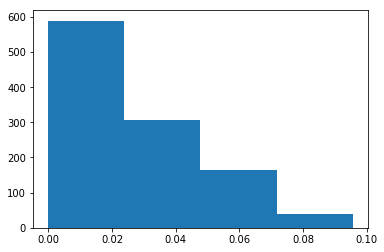

In [16]:
(pf['count_zeros']/len(pf['count_zeros'])).hist(grid=False,bins=4)

In [20]:
f_df_ = f_df.reset_index()

In [23]:
f_df_['year'] = f_df_['date'].apply(lambda x: x.year)

Text(0,0.5,'std')

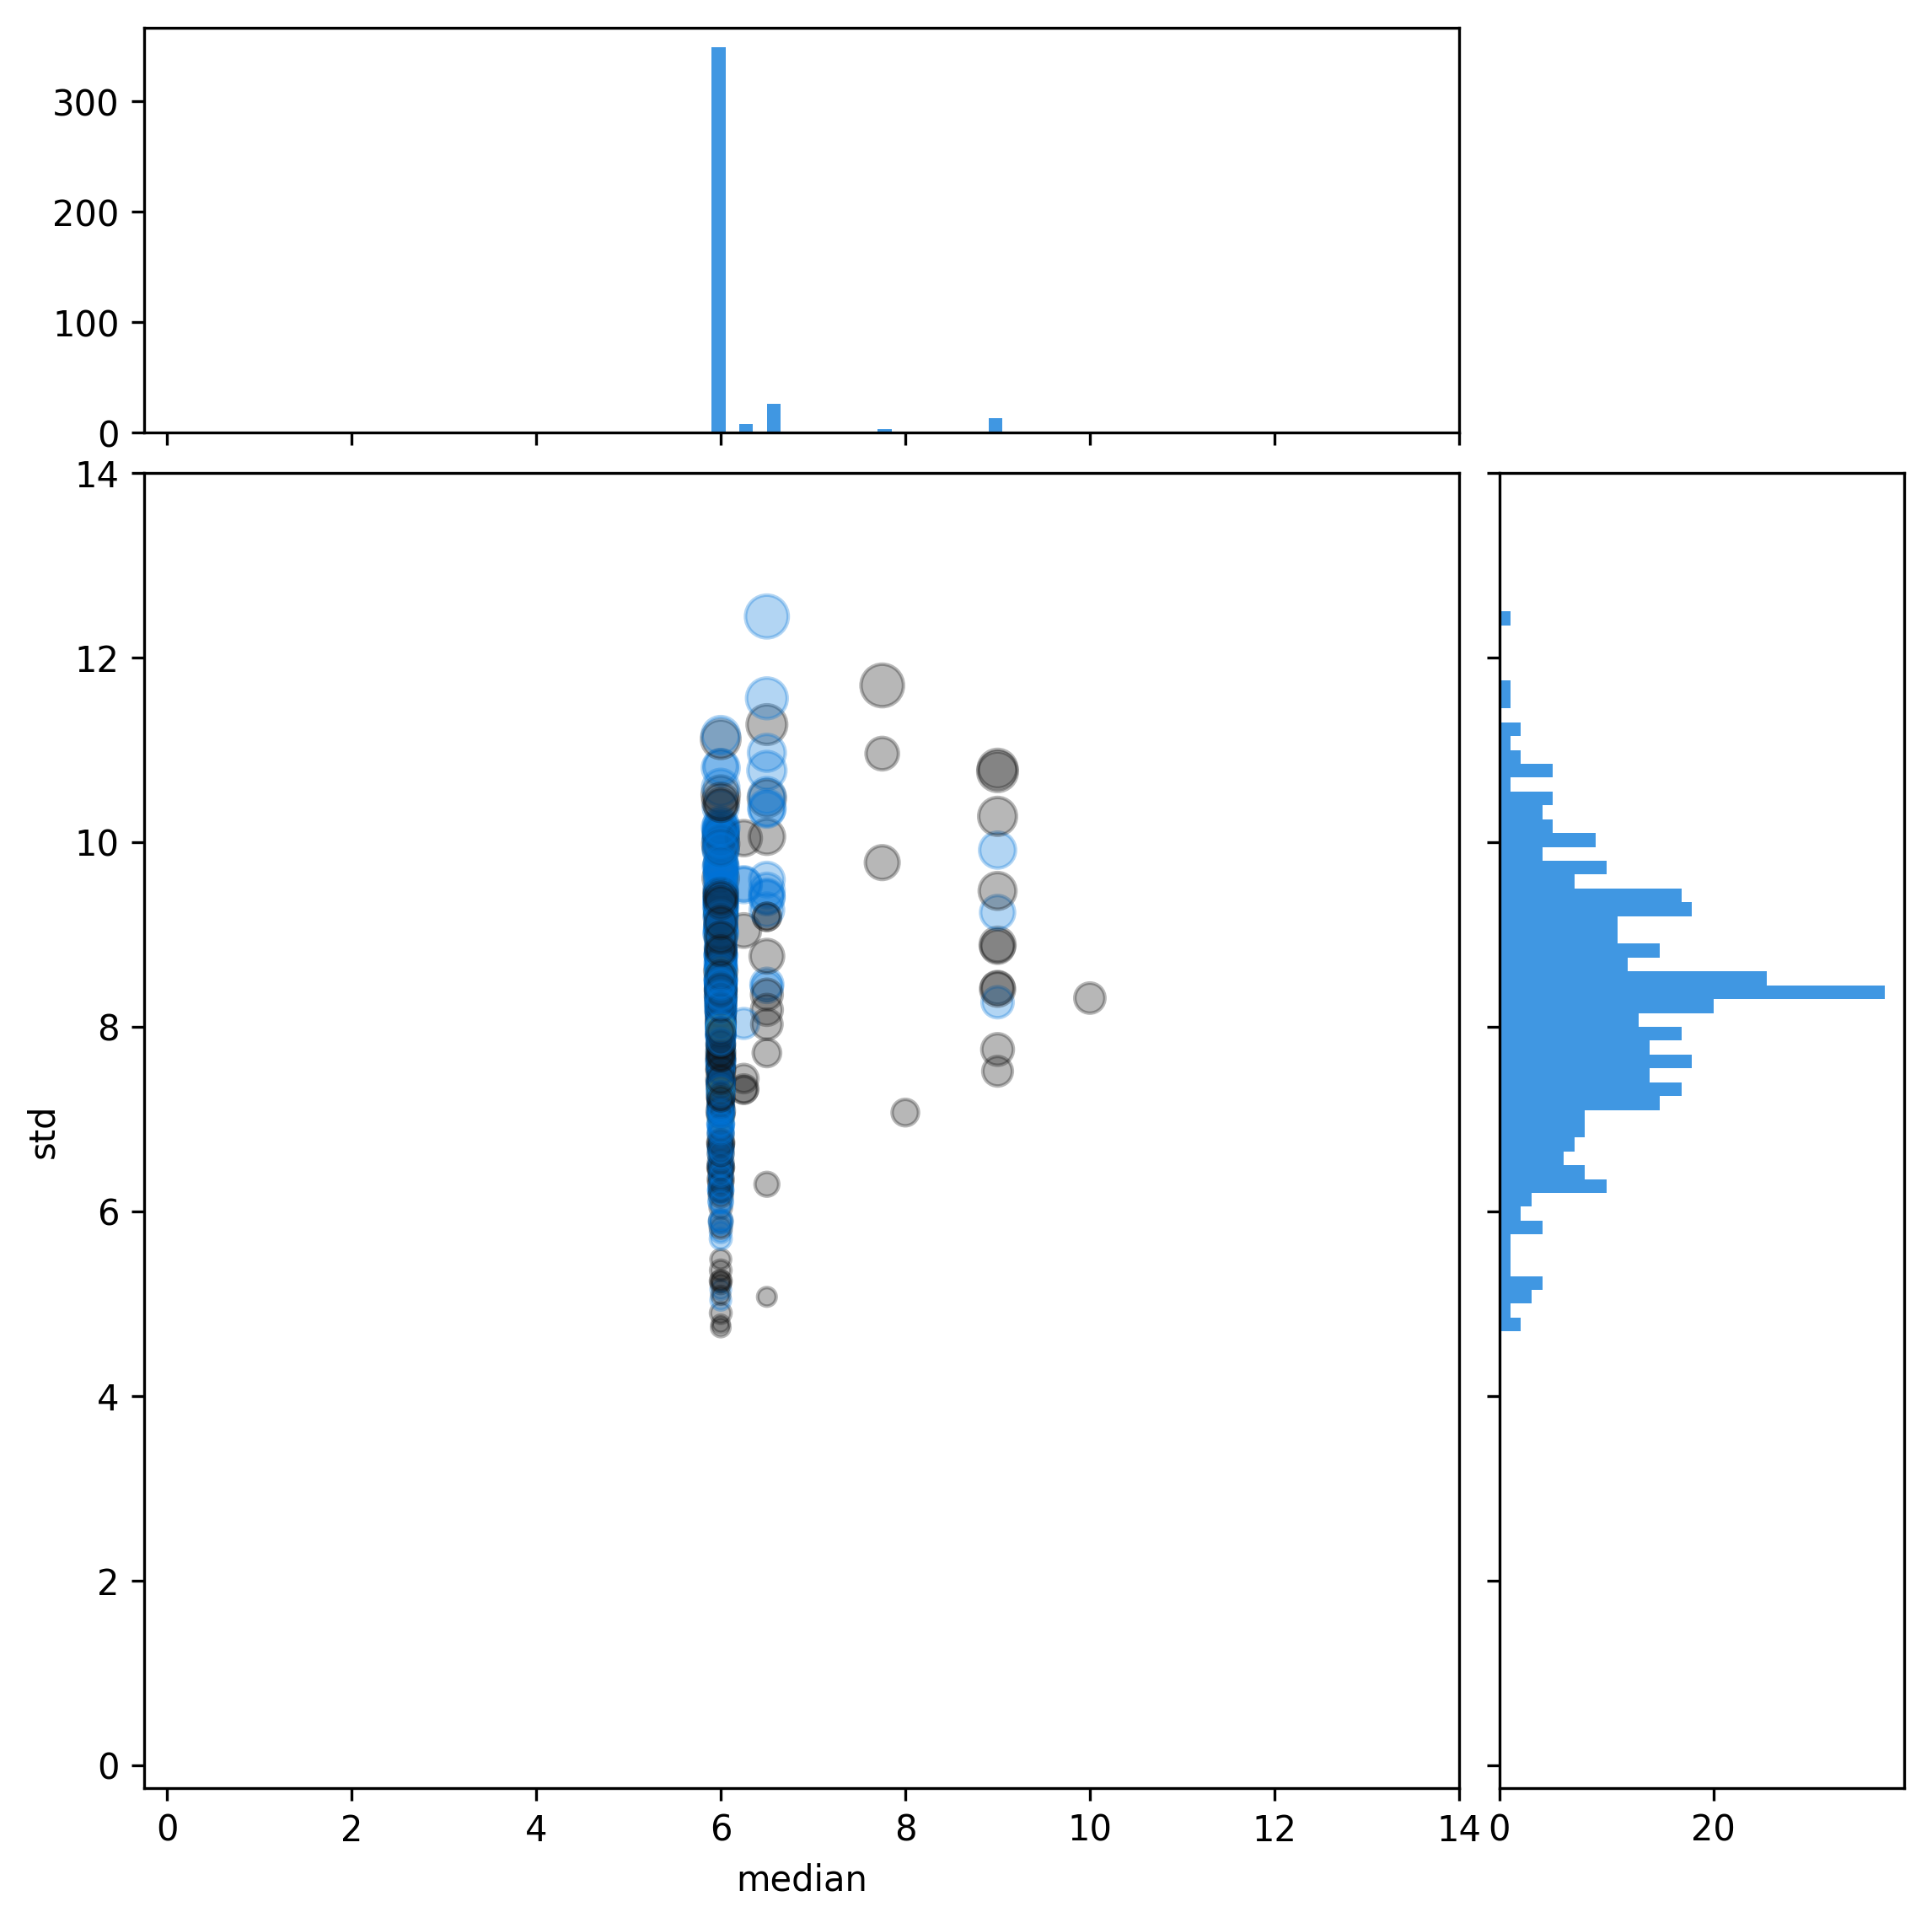

In [32]:
pf = f_df_.reset_index().groupby(['batter','year']).agg(
    {'f_score':['mean','median','std',
     'count',count_zeros]})['f_score'].dropna()

pf_ = pf[pf['mean'] > 0]
pf_['zero_color'] = np.where(pf_['count_zeros'] > 60, '#FF4136',
         np.where(pf_['count_zeros'] > 40, '#FFDC00',
                  np.where(pf_['count_zeros'] > 20, '#0074D9','#111111')))
pf_['m*s'] = pf_['mean']*pf_['std']
pf_ = pf_[pf_['m*s']>20]

####
pf_ = pf_[(pf_['median'] >5)]
###
size = 'count'
X,Y = 'median','std'
x = pf_[X]
y = pf_[Y]
Size=pf_[size]
Color = pf_['zero_color']

nullfmt = NullFormatter()
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(8, 8),dpi=300)

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# the scatter plot:
axScatter.scatter(x, y, alpha=.3, c=Color, s=pf_['m*s'])#(Size/Size.max())*10)

# now determine nice limits by hand:
binwidth = 0.15
xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
lim_pos = (int(xymax/binwidth) + 1) * binwidth
xymin = np.max([np.min(np.fabs(x)), np.min(np.fabs(y))])
lim_neg = (int(xymin/binwidth) - 1) * binwidth

lim_pos, lim_neg = 14, -.25

axScatter.set_xlim((lim_neg, lim_pos))
axScatter.set_ylim((lim_neg, lim_pos))

bins = np.arange(lim_neg, lim_pos + binwidth, binwidth)
axHistx.hist(x, bins=bins, color='#0074D9',alpha=.75)
axHisty.hist(y, bins=bins, orientation='horizontal', color='#0074D9',alpha=.75)

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())

axScatter.set_xlabel(X)
axScatter.set_ylabel(Y)

In [10]:
pf_.to_pickle('player_fantasy.pickle')

# Additional Player Data to DFS

In [11]:
pf_.head()

,mean,median,std,count,count_zeros,zero_color,m*s
batter,,,,,,,
abrej003,9.397849,6.0,9.351036,279,57.0,#FFDC00,87.879624
acunr001,9.981651,6.5,10.060679,109,18.0,#111111,100.422186
adaml001,3.526882,0.0,5.909354,93,50.0,#FFDC00,20.841593
adamm002,6.351240,3.0,9.393240,242,105.0,#FF4136,59.658721
adamw002,6.552941,6.0,6.381252,85,19.0,#111111,41.815970
